# Predicting no-show patients at a Dental Practice

## Introduction

### Goal
To document steps used to create a machine learning algorithm that predicts patient attendance.

### Steps

1) Feature Engineering

2) Building ML model

3) Hyperparameter Tuning

4) Visualizing model output





## 1) Automatic Feature Creation using featuretools

In [701]:
import featuretools as ft
import featuretools.variable_types as vtypes
import pandas as pd
import os
import multiprocess as mp
import pickle

# Load the model from disk
weather = pickle.load(open('data/weather2018.pkl', 'rb'))
weather = pd.DataFrame(weather)

#read current working directory
##assume running notebook from No_show_patience directory
cwd = os.getcwd()


#import and load data
full_dataset = pd.read_pickle(cwd + "/data/preFT2018.pkl")
#use below code at experimentation stage to build new features on a small dataset.
#full_dataset = full_dataset.iloc[:5,:]

full_dataset.AppointmentDate = (pd.to_datetime(full_dataset.AppointmentDate) + 
                                (pd.Timedelta(days = 1) - pd.Timedelta(seconds = 1)) * (full_dataset.noshow))





In [702]:
#full_dataset[variable_list].iloc[0:9,:].to_csv(cwd + "/data/head.csv")

In [703]:

x = full_dataset['AppointmentDate'].dt.round('60min')
full_dataset['datetime'] = pd.to_datetime(x)
weather['datetime'] = pd.to_datetime(weather['time'],unit='s').dt.round('60min')
full_dataset = full_dataset.merge(weather,on='datetime', how="left")

In [704]:
full_dataset.iloc[:2,20:45]

,source,procedure,weekday,apptType,AppointmentId,datetime,time,summary,icon,precipIntensity,...,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,precipType,precipAccumulation,ozone
0,Source_no_reported_source,Procedures_others,Wednesday,Hygiene,0,2018-09-26 14:00:00,1537970400,Mostly Cloudy,partly-cloudy-day,0,...,1016.71,5.94,5.94,182,0.55,3,7.197,NaN,NaN,273.1
1,Source_Google,"Procedures_D0220, D0230, D0140",Thursday,Restorative,1,2018-06-21 09:00:00,1529571600,Partly Cloudy,partly-cloudy-night,0,...,1007.07,1.15,1.15,207,0.43,0,5.282,NaN,NaN,NaN


In [705]:
full_dataset.columns

Index(['PatientId', 'AppointmentDate', 'AppointmentDay', 'newbie',
       'insuranceDummy', 'guarantorIsPatient', 'loyalty', 'noshow',
       'newpatientfile', 'Age_npf', 'Patient', 'PatientPhone1', 'PatientEmail',
       'GuarantorEmail', 'num_past_noshow', 'patientEmailDomain',
       'guarantorEmailDomain', 'patientPhone1AreaCode', 'insurance',
       'provider', 'source', 'procedure', 'weekday', 'apptType',
       'AppointmentId', 'datetime', 'time', 'summary', 'icon',
       'precipIntensity', 'precipProbability', 'temperature',
       'apparentTemperature', 'dewPoint', 'humidity', 'pressure', 'windSpeed',
       'windGust', 'windBearing', 'cloudCover', 'uvIndex', 'visibility',
       'precipType', 'precipAccumulation', 'ozone'],
      dtype='object')

In [706]:
variable_types = {'PatientId':vtypes.Numeric, 'newbie':vtypes.Boolean,'insuranceDummy':vtypes.Boolean, 
                  'guarantorIsPatient':vtypes.Boolean, 'loyalty':vtypes.Numeric, 'noshow':vtypes.Boolean, 
                  'PatientEmail':vtypes.EmailAddress,'GuarantorEmail':vtypes.EmailAddress,
                  'PatientPhone1':vtypes.PhoneNumber, 'patientEmailDomain':vtypes.Categorical,
                  'guarantorEmailDomain':vtypes.Categorical, 'patientPhone1AreaCode':vtypes.Categorical, 
                  'insurance':vtypes.Categorical, 'provider':vtypes.Categorical, 
                  'source':vtypes.Categorical, 'procedure':vtypes.Categorical,
                  'weekday':vtypes.Categorical, 'apptType':vtypes.Categorical,
                  "newpatientfile":vtypes.Ordinal, "Age_npf":vtypes.Numeric, "Patient":vtypes.Text,
                  'summary':vtypes.Text, 'icon':vtypes.Text, 'precipIntensity':vtypes.Numeric, 
                  'temperature':vtypes.Numeric,'apparentTemperature':vtypes.Numeric, 'dewPoint':vtypes.Numeric,
                  'humidity':vtypes.Numeric, 'pressure':vtypes.Numeric, 'windSpeed':vtypes.Numeric,
                  'windGust':vtypes.Numeric, 'windBearing':vtypes.Numeric, 'cloudCover':vtypes.Numeric,
                 }
variable_list = (['PatientId', 'AppointmentDate', 'newbie',
                  'insuranceDummy', 'guarantorIsPatient', 'loyalty', 'noshow',
                  'PatientEmail', 'GuarantorEmail', 'PatientPhone1', 
                  'patientEmailDomain', 'guarantorEmailDomain', 'patientPhone1AreaCode',
                  'insurance','provider', 'source','procedure', 'weekday', 'apptType', 
                  "newpatientfile", "Age_npf", "Patient", 'AppointmentId','summary', 'icon',
                  'precipIntensity', 'temperature',
                  'apparentTemperature', 'dewPoint', 'humidity', 'pressure', 'windSpeed',
                  'windGust', 'windBearing', 'cloudCover'])

# Make an entity named 'appointments' which stores dataset metadata with the dataframe
es = ft.EntitySet('Appointments')
es = es.entity_from_dataframe(entity_id="appointments",
                              dataframe=full_dataset[variable_list],
                              index='AppointmentId',
                              time_index='AppointmentDate',
                              variable_types=variable_types)
es['appointments']

# Make patients, weekdays, emails and insurances entities

es.normalize_entity(base_entity_id='appointments', new_entity_id='patients', index='PatientId', 
                    additional_variables = ['Patient', 'PatientEmail', 'GuarantorEmail', 'PatientPhone1',
                                            'newpatientfile', 'Age_npf'], make_time_index=True)
# 'PatientEmail', 'GuarantorEmail', 'PatientPhone1'
es.normalize_entity('appointments', 'patientemails', 'patientEmailDomain', make_time_index=True)
es.normalize_entity('appointments', 'guarantoremails', 'guarantorEmailDomain', make_time_index=True)
es.normalize_entity('appointments', 'patientPhones', 'patientPhone1AreaCode',make_time_index=True)
es.normalize_entity('appointments', 'insurances', 'insurance',make_time_index=True)
es.normalize_entity('appointments', 'providers', 'provider', make_time_index=True)
es.normalize_entity('appointments', 'sources', 'source', make_time_index=True)
es.normalize_entity('appointments', 'procedures', 'procedure', make_time_index=True)
es.normalize_entity('appointments', 'weekdays', 'weekday', make_time_index=True)
es.normalize_entity('appointments', 'apptTypes', 'apptType',make_time_index=True)


Entityset: Appointments
  Entities:
    appointments [Rows: 5471, Columns: 29]
    patients [Rows: 2020, Columns: 8]
    patientemails [Rows: 9, Columns: 2]
    guarantoremails [Rows: 8, Columns: 2]
    patientPhones [Rows: 8, Columns: 2]
    insurances [Rows: 9, Columns: 2]
    providers [Rows: 4, Columns: 2]
    sources [Rows: 6, Columns: 2]
    procedures [Rows: 21, Columns: 2]
    weekdays [Rows: 5, Columns: 2]
    apptTypes [Rows: 3, Columns: 2]
  Relationships:
    appointments.PatientId -> patients.PatientId
    appointments.patientEmailDomain -> patientemails.patientEmailDomain
    appointments.guarantorEmailDomain -> guarantoremails.guarantorEmailDomain
    appointments.patientPhone1AreaCode -> patientPhones.patientPhone1AreaCode
    appointments.insurance -> insurances.insurance
    appointments.provider -> providers.provider
    appointments.source -> sources.source
    appointments.procedure -> procedures.procedure
    appointments.weekday -> weekdays.weekday
    appointmen

In [707]:
print(es)

Entityset: Appointments
  Entities:
    appointments [Rows: 5471, Columns: 29]
    patients [Rows: 2020, Columns: 8]
    patientemails [Rows: 9, Columns: 2]
    guarantoremails [Rows: 8, Columns: 2]
    patientPhones [Rows: 8, Columns: 2]
    insurances [Rows: 9, Columns: 2]
    providers [Rows: 4, Columns: 2]
    sources [Rows: 6, Columns: 2]
    procedures [Rows: 21, Columns: 2]
    weekdays [Rows: 5, Columns: 2]
    apptTypes [Rows: 3, Columns: 2]
  Relationships:
    appointments.PatientId -> patients.PatientId
    appointments.patientEmailDomain -> patientemails.patientEmailDomain
    appointments.guarantorEmailDomain -> guarantoremails.guarantorEmailDomain
    appointments.patientPhone1AreaCode -> patientPhones.patientPhone1AreaCode
    appointments.insurance -> insurances.insurance
    appointments.provider -> providers.provider
    appointments.source -> sources.source
    appointments.procedure -> procedures.procedure
    appointments.weekday -> weekdays.weekday
    appointmen

In [ ]:
cutoff_times =  es['appointments'].df[['AppointmentId','AppointmentDate']]
cat_cols = ['insurance','provider', 'procedure', 'patientEmailDomain', 'guarantorEmailDomain', 
            'patientPhone1AreaCode','weekday', 'apptType','source']

X_ft, features = ft.dfs(entityset=es,
                        target_entity='appointments',
                        agg_primitives=['count', 'percent_true', 'num_true', 'trend', 'skew', 'all', 'std',
                                       'max', 'mean', 'min', 'median', 'num_unique'],
                        max_depth=3,
                        trans_primitives=['day', 'month', 'year', 'num_words', 'num_characters'],
                        cutoff_time=cutoff_times,
                        verbose=True,
                        approximate = '3h',
                        #approximate = "1 day",
                        chunk_size=50,
                        n_jobs=mp.cpu_count())

Built 1366 features
EntitySet scattered to 4 workers in 21 seconds          
Elapsed: 06:10 | Progress:  10%|█         | Remaining: 1:30:54

In [409]:
X_ft.head()

,precipProbability,PatientId,newbie,insuranceDummy,guarantorIsPatient,loyalty,noshow,patientEmailDomain,guarantorEmailDomain,patientPhone1AreaCode,...,apptTypes.MIN(appointments.NUM_WORDS(icon)),apptTypes.MIN(appointments.NUM_CHARACTERS(summary)),apptTypes.MIN(appointments.NUM_CHARACTERS(icon)),apptTypes.MEDIAN(appointments.NUM_WORDS(summary)),apptTypes.MEDIAN(appointments.NUM_WORDS(icon)),apptTypes.MEDIAN(appointments.NUM_CHARACTERS(summary)),apptTypes.MEDIAN(appointments.NUM_CHARACTERS(icon)),apptTypes.NUM_UNIQUE(appointments.DAY(AppointmentDate)),apptTypes.NUM_UNIQUE(appointments.MONTH(AppointmentDate)),apptTypes.NUM_UNIQUE(appointments.YEAR(AppointmentDate))
AppointmentId,,,,,,,,,,,,,,,,,,,,,
319,0,9608,0,0,True,19,0,PatientEmail_gmail.com,GuarantorEmail_gmail.com,PatientPhone1_434,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1526,0,9393,0,0,True,10,0,PatientEmail_others,GuarantorEmail_others,PatientPhone1_434,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4249,0,9200,0,1,True,24,0,PatientEmail_gmail.com,GuarantorEmail_gmail.com,PatientPhone1_others,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,0,8562,0,0,True,19,0,PatientEmail_others,GuarantorEmail_others,PatientPhone1_434,...,1.0,5.0,11.0,1.0,1.0,5.0,11.0,1.0,1.0,1.0
1942,0,9961,0,0,True,19,0,PatientEmail_GMAIL.COM,GuarantorEmail_GMAIL.COM,PatientPhone1_540,...,1.0,5.0,11.0,1.0,1.0,5.0,11.0,1.0,1.0,1.0


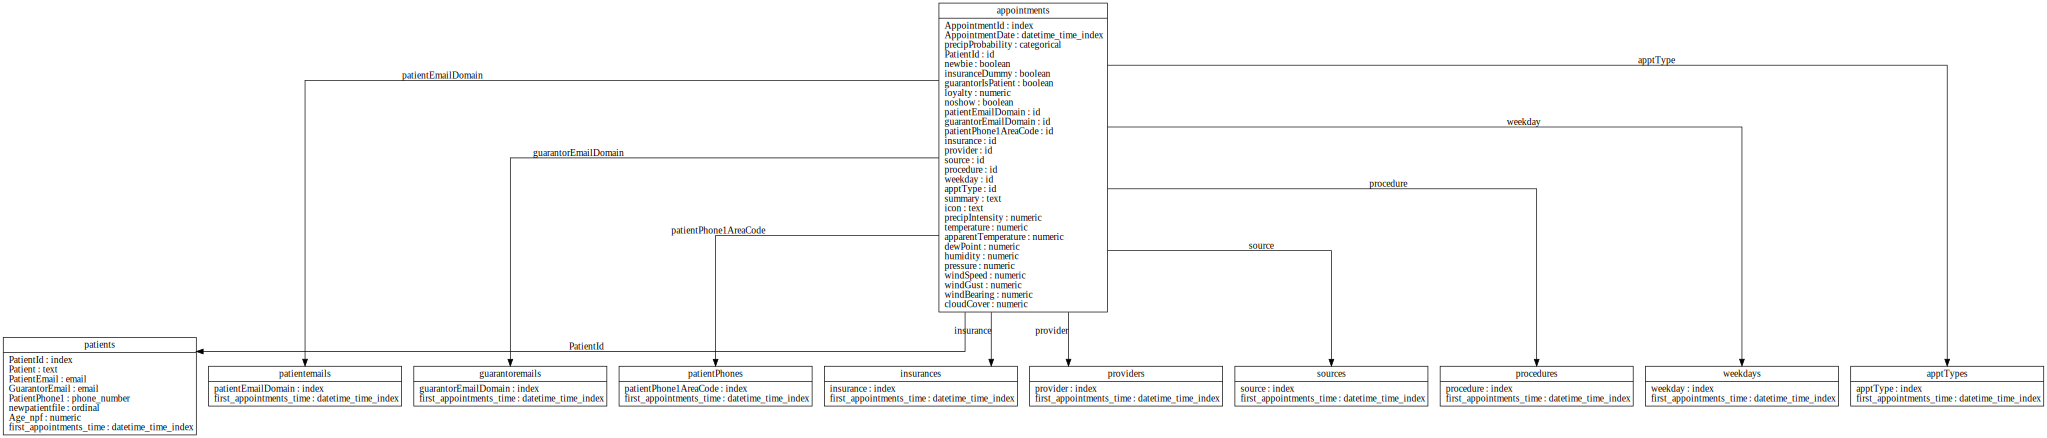

In [410]:
es.plot()

## 2) Building ML models

In [411]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score
import pandas as pd
import numpy as np
import multiprocess as mp
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import GridSearchCV
import os

cwd = os.getcwd()

In [412]:
##choose to drop cat cols
cat_cols = ['insurance','provider', 'procedure', 'patientEmailDomain', 'guarantorEmailDomain', 
            'patientPhone1AreaCode','weekday', 'apptType','source']


In [413]:
#pickle that data set. only do this when you want to replace
#X_ft.drop(cat_cols,axis=1).to_pickle(cwd + "/data/postFT_insight_weather.pkl")
#full_dataset = pd.read_pickle(cwd + "/data/postFT_insight.pkl")

In [414]:
##skip this step if loading in pickle
##choose to drop cat cols
cat_cols = ['insurance','provider', 'procedure', 'patientEmailDomain', 'guarantorEmailDomain', 
           'patientPhone1AreaCode','weekday', 'apptType','source']


##import and load data
full_dataset = pd.concat([X_ft],axis=1).drop(cat_cols,axis=1)

In [415]:
##if loading pickle, drop in here
X = full_dataset.drop(['noshow'],axis=1)
y = full_dataset[['noshow']]



In [416]:
X

,precipProbability,PatientId,newbie,insuranceDummy,guarantorIsPatient,loyalty,precipIntensity,temperature,apparentTemperature,dewPoint,...,apptTypes.MIN(appointments.NUM_WORDS(icon)),apptTypes.MIN(appointments.NUM_CHARACTERS(summary)),apptTypes.MIN(appointments.NUM_CHARACTERS(icon)),apptTypes.MEDIAN(appointments.NUM_WORDS(summary)),apptTypes.MEDIAN(appointments.NUM_WORDS(icon)),apptTypes.MEDIAN(appointments.NUM_CHARACTERS(summary)),apptTypes.MEDIAN(appointments.NUM_CHARACTERS(icon)),apptTypes.NUM_UNIQUE(appointments.DAY(AppointmentDate)),apptTypes.NUM_UNIQUE(appointments.MONTH(AppointmentDate)),apptTypes.NUM_UNIQUE(appointments.YEAR(AppointmentDate))
AppointmentId,,,,,,,,,,,,,,,,,,,,,
319,0,9608,0,0,True,19,0.0000,10.89,10.89,-0.74,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1526,0,9393,0,0,True,10,0.0000,10.89,10.89,-0.74,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4249,0,9200,0,1,True,24,0.0000,10.89,10.89,-0.74,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,0,8562,0,0,True,19,0.0000,10.69,10.69,-0.67,...,1.0,5.0,11.0,1.0,1.0,5.0,11.0,1.0,1.0,1.0
1942,0,9961,0,0,True,19,0.0000,10.69,10.69,-0.67,...,1.0,5.0,11.0,1.0,1.0,5.0,11.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3695,0.1,10792,1,0,True,10,0.0021,61.95,62.49,61.60,...,1.0,0.0,0.0,1.0,1.0,8.0,11.0,31.0,12.0,1.0
3969,0.1,6733,0,0,True,30,0.0021,61.95,62.49,61.60,...,1.0,0.0,0.0,1.0,1.0,8.0,11.0,31.0,12.0,1.0
4364,0.35,4093,0,0,True,30,0.0028,62.28,62.73,61.23,...,1.0,0.0,0.0,1.0,1.0,8.0,11.0,31.0,12.0,1.0


In [417]:
#split 2018 data into training and test sets, setting a seed for replication purposes
cutoff_month = 8
X_train, X_test, y_train, y_test = (X[X['MONTH(AppointmentDate)']<=cutoff_month],
                                    X[X['MONTH(AppointmentDate)']>cutoff_month],
                                    y[X['MONTH(AppointmentDate)']<=cutoff_month],
                                    y[X['MONTH(AppointmentDate)']>cutoff_month])


# Explicitly impute values for missing fields for RF and Log
X_train, X_test = X_train.fillna(X_train.mean()), X_test.fillna(X_test.mean())
X_train, X_test = X_train.fillna(0), X_test.fillna(0)



In [418]:
#logistic regression model
model_log = LogisticRegression(solver="liblinear", C=0.5, random_state=1).fit(X_train,y_train) ## train on data
y_pred_model_log = model_log.predict_proba(X_test) #predict on test set

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [419]:
from sklearn.ensemble import RandomForestClassifier
#random forest model
model_rf = RandomForestClassifier(n_estimators=1000, random_state=1).fit(X_train,y_train) ## train on data
y_pred_model_rf = model_rf.predict_proba(X_test) #predict on test set

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [420]:
##XGBoost
from xgboost import XGBClassifier, plot_importance

#XGB - automatically deals with missing values during training
model_xgb = (XGBClassifier(n_estimators=50, max_depth = 3, eta = 0.1, subsample = 0.6, 
                           n_thread = 4, random_state=1, alpha = 0,
                           tree_method = 'hist').fit(X_train,y_train.values.ravel()))
y_pred_model_xgb = model_xgb.predict_proba(X_test)

In [421]:
print("The AUC score of the Log Reg model is: " + str(np.round(roc_auc_score(y_test,pd.DataFrame(y_pred_model_log)[1]),2)))
print("The AUC score of the RF model is: " + str(np.round(roc_auc_score(y_test,pd.DataFrame(y_pred_model_rf)[1]),2)))
print("The AUC score of the XGB model is: " + str(np.round(roc_auc_score(y_test,pd.DataFrame(y_pred_model_xgb)[1]),2)))


The AUC score of the Log Reg model is: 0.54
The AUC score of the RF model is: 0.61
The AUC score of the XGB model is: 0.73


### 3) Hyperparameter Tuning

In [426]:
score = 'roc_auc' #originally also roc_auc

#### max depth

In [427]:
#max depth
param_test2 = {'max_depth':range(5,45,10)}

gsearch2 = GridSearchCV(estimator = XGBClassifier(n_estimators=200,max_depth = 5, eta = 0.15076, subsample = 0.62141,
                                                  n_thread = 4, random_state=1, alpha = 0,tree_method = 'hist'),
                        cv=5, param_grid = param_test2, scoring=score, iid=False)

gsearch2.fit(X_train,y_train.values.ravel())
gsearch2.best_params_, gsearch2.best_score_



({'max_depth': 5}, 0.4294061753523343)

In [550]:
#max depth fine tune
param_test3 = {'max_depth':[1,2,3,4,5]}

gsearch3 = GridSearchCV(estimator = XGBClassifier(n_estimators=200,max_depth = 5, eta = 0.15076, subsample = 0.62141,
                                                  n_thread = 4, random_state=1, alpha = 0,tree_method = 'hist'),
                        cv=5, param_grid = param_test3, scoring=score, iid=False)

gsearch3.fit(X_train,y_train.values.ravel())
gsearch3.best_params_, gsearch3.best_score_



({'max_depth': 1}, 0.5252645728348619)

#### max estimators

In [433]:
#n_estimators
param_test4 = {'n_estimators':range(200,2000,200)}

gsearch4 = GridSearchCV(estimator = XGBClassifier(n_estimators=200,max_depth = 15, eta = 0.15, subsample = 0.05,
                                                  n_thread = 4, random_state=1, alpha = 0,tree_method = 'hist'),
                        cv=5, param_grid = param_test4, scoring=score, iid=False)

gsearch4.fit(X_train,y_train.values.ravel())
gsearch4.best_params_, gsearch4.best_score_


({'n_estimators': 1400}, 0.39451219942824595)

In [ ]:
#n_estimators
# param_test4 = {'n_estimators':[6,12,25, 50, 100,200]}

# gsearch4 = GridSearchCV(estimator = XGBClassifier(n_estimators=200,max_depth = 2, eta = 0.15076, subsample = 0.62141,
#                                                   n_thread = 4, random_state=1, alpha = 0,tree_method = 'hist'),
#                         cv=5, param_grid = param_test4, scoring=score, iid=False)

# gsearch4.fit(X_train,y_train.values.ravel())
# gsearch4.best_params_, gsearch4.best_score_

#### eta

In [429]:
#eta
param_test5 = {'eta':[i/20.0 for i in range(1,8)]}

gsearch5 = GridSearchCV(estimator = XGBClassifier(n_estimators=200,max_depth = 2, eta = 0.15076, subsample = 0.62141,
                                                  n_thread = 4, random_state=1, alpha = 0,tree_method = 'hist'),
                        cv=5, param_grid = param_test5, scoring=score, iid=False)

gsearch5.fit(X_train,y_train.values.ravel())
gsearch5.best_params_, gsearch5.best_score_


({'eta': 0.05}, 0.4695702357086097)

#### subsample

In [430]:
#subsample
param_test6 = {'subsample':[i/10.0 for i in range(1,9,2)]}

gsearch6 = GridSearchCV(estimator = XGBClassifier(n_estimators=200,max_depth = 2, eta = 0.05, subsample = 0.62141,
                                                  n_thread = 4, random_state=1, alpha = 0,tree_method = 'hist'),
                        cv=5, param_grid = param_test6, scoring=score, iid=False)

gsearch6.fit(X_train,y_train.values.ravel())
gsearch6.best_params_, gsearch6.best_score_


({'subsample': 0.7}, 0.48850880411072073)

#### alpha 

In [431]:
#alpha rate
param_test1 = {'alpha':[0, 1e-2, 0.1, 1, 10, 100, 1000]}

gsearch1 = GridSearchCV(estimator = XGBClassifier(n_estimators=800,max_depth = 3, eta = 0.05, subsample = 0.5,
                                                  n_thread = 4, random_state=1, alpha = 0.5,tree_method = 'hist'),
                        cv=5, param_grid = param_test1, scoring=score, iid=False)

gsearch1.fit(X_train,y_train.values.ravel())
gsearch1.best_params_, gsearch1.best_score_
##alpha of 0 is best

({'alpha': 0}, 0.452583278480195)

#### gamma

In [438]:
import numpy as np
#gamma rate
param_test7 = {'gamma':[0.0, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0]}

gsearch7 = GridSearchCV(estimator = XGBClassifier(n_estimators=200,max_depth = 2, eta = 0.05, subsample = 0.3,
                                                  n_thread = 4, random_state=1, alpha = 0, gamma=0,tree_method = 'hist'),
                        cv=5, param_grid = param_test7, scoring=score, iid=False)

gsearch7.fit(X_train,y_train.values.ravel())
gsearch7.best_params_, gsearch7.best_score_


({'gamma': 16.0}, 0.46834822660837644)

In [439]:
#gamma rate
param_test7 = {'gamma':[16.0, 32.0]}
gsearch7 = GridSearchCV(estimator = XGBClassifier(n_estimators=200,max_depth = 2, eta = 0.05, subsample = 0.3,
                                                  n_thread = 4, random_state=1, alpha = 0, gamma=0,tree_method = 'hist'),
                        cv=5, param_grid = param_test7, scoring=score, iid=False)

gsearch7.fit(X_train,y_train.values.ravel())
gsearch7.best_params_, gsearch7.best_score_

({'gamma': 16.0}, 0.46834822660837644)

#### all together

In [ ]:
param_test8 = {'gamma':[np.arange(0, 10, 0.5)],
               'max_depth':[range(5,30,5)],
               'n_estimators':[range(200,2000,200)],
               'eta':[i/20.0 for i in range(1,6)],
               'subsample':[i/10.0 for i in range(1,9,2)],
              }
eval_set = [X_test, y_test.values.ravel()]
gsearch8 = GridSearchCV(estimator = XGBClassifier(n_estimators=1000,max_depth = 5, eta = 0.05, subsample = 0.3,
                                                  n_thread = 4, random_state=1, alpha = 0, gamma=0,tree_method = 'hist',eval_metric='auc', eval_set=eval_set,early_stopping_rounds=10),
                        cv=5, param_grid = param_test8, scoring='roc_auc', iid=False)


gsearch8.fit(X_train,y_train.values.ravel())
gsearch8.best_params_, gsearch8.best_score_
#parameters for roc_auc without weather
# ({'eta': 0.05,
#   'gamma': 0.0,
#   'max_depth': 1,
#   'n_estimators': 25,
#   'subsample': 0.5},
#  0.582821084090225)


In [549]:
##XGBoost with updated stuff
from xgboost import XGBClassifier, plot_importance

eval_set = [(X_train, y_train.values.ravel()), (X_test, y_test.values.ravel())]

#XGB - automatically deals with missing values during training
model_xgb_PT = XGBClassifier(n_estimators=1400, max_depth = 5, eta = 0.05, subsample = 0.7, 
                           n_thread = 4, random_state=1, alpha = 0,gamma =25,objective= 'binary:logistic',
                           tree_method = 'hist').fit(X_train, y_train.values.ravel(), 
                                                     eval_metric=["error", "logloss","auc"], eval_set=eval_set,early_stopping_rounds=10, verbose=False)
y_pred_model_xgb_PT = model_xgb_PT.predict_proba(X_test)
print("The AUC score of the XGB model is: " + str(np.round(roc_auc_score(y_test,pd.DataFrame(y_pred_model_xgb_PT)[1]),2)))


The AUC score of the XGB model is: 0.73


### 4) Visualizing Model 


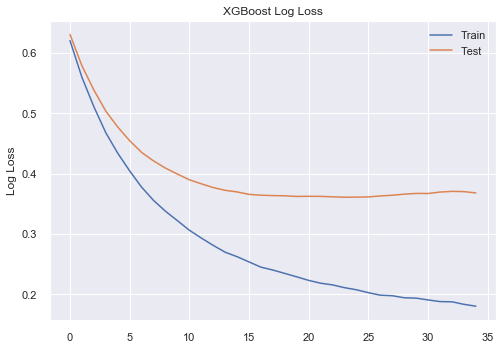

In [455]:
from matplotlib import pyplot

# retrieve performance metrics
results = model_xgb_PT.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


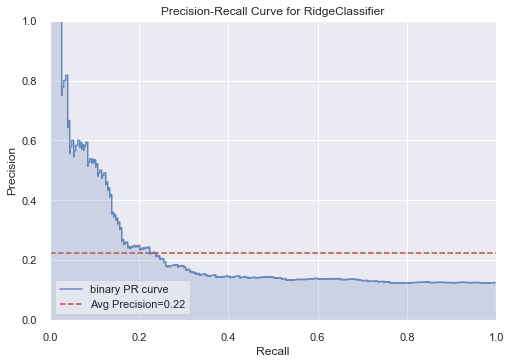

In [442]:
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split as tts
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.datasets import load_spam

# Create the visualizer, fit, score, and poof it
viz = PrecisionRecallCurve(RidgeClassifier())
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.poof()

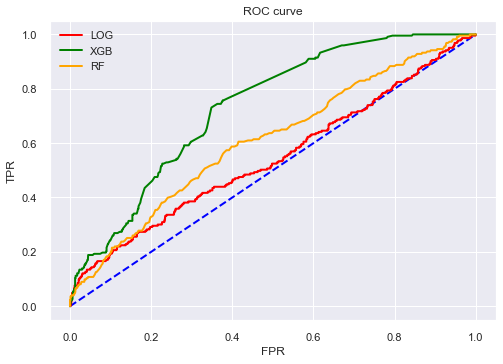

In [551]:
##comparing LOG, XGB, RF

import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_importance

##calculate false positive and true positive rates
fpr, tpr,_=roc_curve(y_test,pd.DataFrame(y_pred_model_log)[1],drop_intermediate=False)
fpr_2, tpr_2,_=roc_curve(y_test,pd.DataFrame(y_pred_model_xgb_PT)[1],drop_intermediate=False)
fpr_3, tpr_3,_=roc_curve(y_test,pd.DataFrame(y_pred_model_rf)[1],drop_intermediate=False)


# plot ROC and reference
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.plot(fpr, tpr, color='red', lw=2, label='LOG')
plt.plot(fpr_2, tpr_2, color='green', lw=2, label='XGB')
plt.plot(fpr_3, tpr_3, color='orange', lw=2, label='RF')

##Title and label

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC curve')

plt.savefig('/Users/aishagharsalli/Documents/dental_predictive_tools/02-20-2019 data pull/figures/MVP_ROCcurve.png')
plt.show()

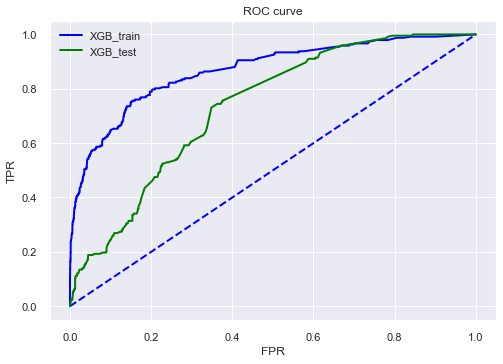

In [552]:
import matplotlib.pyplot as plt

y_pred_model_xgb_train = model_xgb_PT.predict_proba(X_train)

##comparing ROC for XGB train and test
fpr_2, tpr_2,_=roc_curve(y_test,pd.DataFrame(y_pred_model_xgb_PT)[1],drop_intermediate=False)
fpr_train, tpr_train,_=roc_curve(y_train,pd.DataFrame(y_pred_model_xgb_train)[1],drop_intermediate=False)


plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='XGB_train')
plt.plot(fpr_2, tpr_2, color='green', lw=2, label='XGB_test')


##Title and label

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC curve')


plt.savefig(cwd + '/data/test_vs_train.png')
plt.show()

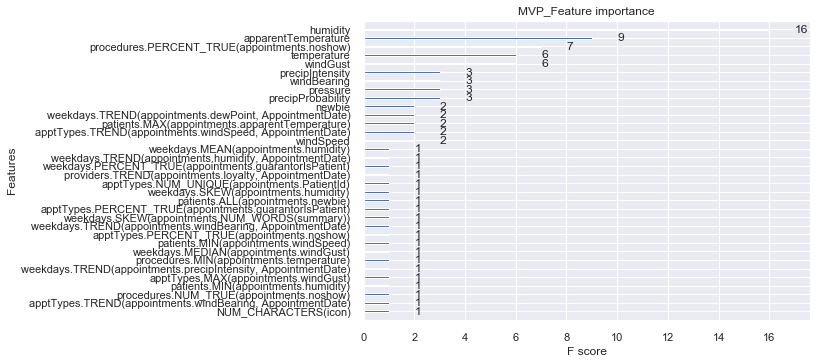

In [553]:
fig, ax = plt.subplots() #figsize=(10, 200)
plot_importance(model_xgb_PT, ax=ax)
plt.title('MVP_Feature importance')

plt.savefig('/Users/aishagharsalli/Documents/dental_predictive_tools/02-20-2019 data pull/figures/MVP_Feature_importance.png')
plt.show()

#### percentage vs no show

In [554]:
y_pred_model_xgb_train = model_xgb_PT.predict_proba(X_train)
train_percent_noshow = pd.DataFrame({'percent_noshow': y_pred_model_xgb_train[:,1]})

In [555]:
##are all indexes the same
same_index = y_train.index == X_train.index
same_index.all()

True

In [556]:
#sanity check. where to call it no shows?
table = pd.concat([X_train['PatientId'].reset_index(drop=True), y_train.reset_index(drop=True), train_percent_noshow.reset_index(drop=True)], axis=1)
table

,PatientId,noshow,percent_noshow
0,9608,0,0.063248
1,9393,0,0.063248
2,9200,0,0.063248
3,8562,0,0.063248
4,9961,0,0.063248
...,...,...,...
3656,7685,0,0.167232
3657,4515,0,0.152911
3658,6830,0,0.178259
3659,1390,1,0.216508


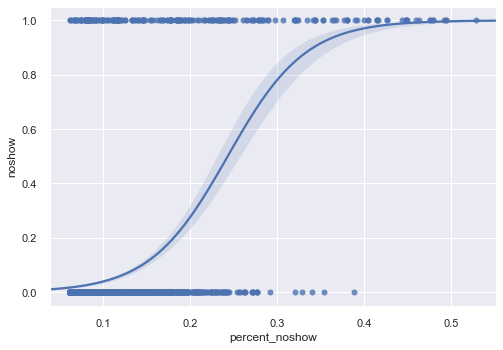

In [557]:
##training data
import seaborn as sns; sns.set(color_codes=True)
ax = sns.regplot(x="percent_noshow", y="noshow",logistic=True, data=table)
fig = ax.get_figure()
fig.savefig("percent_noshow_logistic.png")

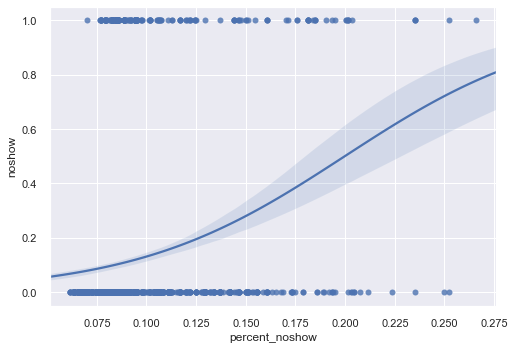

In [558]:
##test_data
percent_noshow = pd.DataFrame({'percent_noshow': y_pred_model_xgb_PT[:,1]})
test_table = pd.concat([X_test['PatientId'].reset_index(drop=True), y_test.reset_index(drop=True), percent_noshow.reset_index(drop=True)], axis=1)

test_logistic = sns.regplot(x="percent_noshow", y="noshow",logistic=True, data=test_table)
test_logistic = test_logistic.get_figure()
test_logistic.savefig("percent_noshow_logistic_test.png")

In [559]:
no_show_likely = test_table[test_table['percent_noshow']>0.18407562]
no_show_unlikely = test_table[test_table['percent_noshow']<0.18407562]
pd.crosstab(no_show_likely.noshow, no_show_likely.percent_noshow)

percent_noshow,0.184861,0.185929,0.186009,0.188870,0.189330,0.190600,0.192137,0.193479,0.193568,0.194155,...,0.203234,0.204727,0.207661,0.211399,0.223558,0.235133,0.249807,0.252304,0.252442,0.265733
noshow,,,,,,,,,,,,,,,,,,,,,
0,0,1,1,1,1,0,1,0,2,1,...,1,2,1,1,1,1,1,0,1,0
1,3,0,0,0,0,1,0,1,0,0,...,1,0,0,0,0,3,0,1,0,1


In [560]:
def minmax(val_list):
    min_val = min(val_list)
    max_val = max(val_list)

    return (min_val, max_val)

In [601]:
gap = minmax(test_table.percent_noshow)
step_size = (gap[1]-gap[0])/100

In [602]:
cutoffs = np.arange(gap[0], gap[1], step_size)
cutoffs

array([0.06158981, 0.06363124, 0.06567267, 0.0677141 , 0.06975553,
       0.07179696, 0.07383839, 0.07587982, 0.07792125, 0.07996268,
       0.08200411, 0.08404554, 0.08608697, 0.0881284 , 0.09016983,
       0.09221126, 0.09425269, 0.09629412, 0.09833555, 0.10037698,
       0.10241841, 0.10445984, 0.10650127, 0.1085427 , 0.11058413,
       0.11262556, 0.11466699, 0.11670842, 0.11874985, 0.12079129,
       0.12283272, 0.12487415, 0.12691558, 0.12895701, 0.13099844,
       0.13303987, 0.1350813 , 0.13712273, 0.13916416, 0.14120559,
       0.14324702, 0.14528845, 0.14732988, 0.14937131, 0.15141274,
       0.15345417, 0.1554956 , 0.15753703, 0.15957846, 0.16161989,
       0.16366132, 0.16570275, 0.16774418, 0.16978561, 0.17182704,
       0.17386847, 0.1759099 , 0.17795133, 0.17999276, 0.18203419,
       0.18407562, 0.18611705, 0.18815848, 0.19019991, 0.19224134,
       0.19428277, 0.1963242 , 0.19836563, 0.20040706, 0.20244849,
       0.20448992, 0.20653135, 0.20857278, 0.21061421, 0.21265

In [603]:
no_show_unlikely[no_show_unlikely.noshow ==0].shape[0] /no_show_unlikely.shape[0]


0.8776301218161683

In [604]:
no_show_likely[no_show_likely.noshow ==1].shape[0] /no_show_likely.shape[0]

0.5

In [660]:
no_show_precision = []
for i in cutoffs:
    no_show_likely = test_table[test_table['percent_noshow']>i]
    no_show_unlikely = test_table[test_table['percent_noshow']<i]
    precision = no_show_likely[no_show_likely.noshow ==1].shape[0] /no_show_likely.shape[0]
    percentage = (i-gap[0])/(gap[1]-gap[0])*100
    proportion = no_show_likely.shape[0] / test_table.shape[0]
    total = no_show_likely.shape[0]
    data = [percentage, precision, proportion, total]
    no_show_precision.append(data)



    
    

In [661]:
test_table.shape[0]

1810

In [685]:
no_show_precision = pd.DataFrame(no_show_precision, columns = ['probability', 'precision', 'proportion', 'total'])
no_show_precision[no_show_precision['probability']>80]

,probability,precision,proportion,total
80,80.0,0.625000,0.004420,8
81,81.0,0.625000,0.004420,8
82,82.0,0.625000,0.004420,8
83,83.0,0.625000,0.004420,8
84,84.0,0.625000,0.004420,8
85,85.0,0.625000,0.004420,8
86,86.0,0.500000,0.002210,4
87,87.0,0.500000,0.002210,4
88,88.0,0.500000,0.002210,4
89,89.0,0.500000,0.002210,4


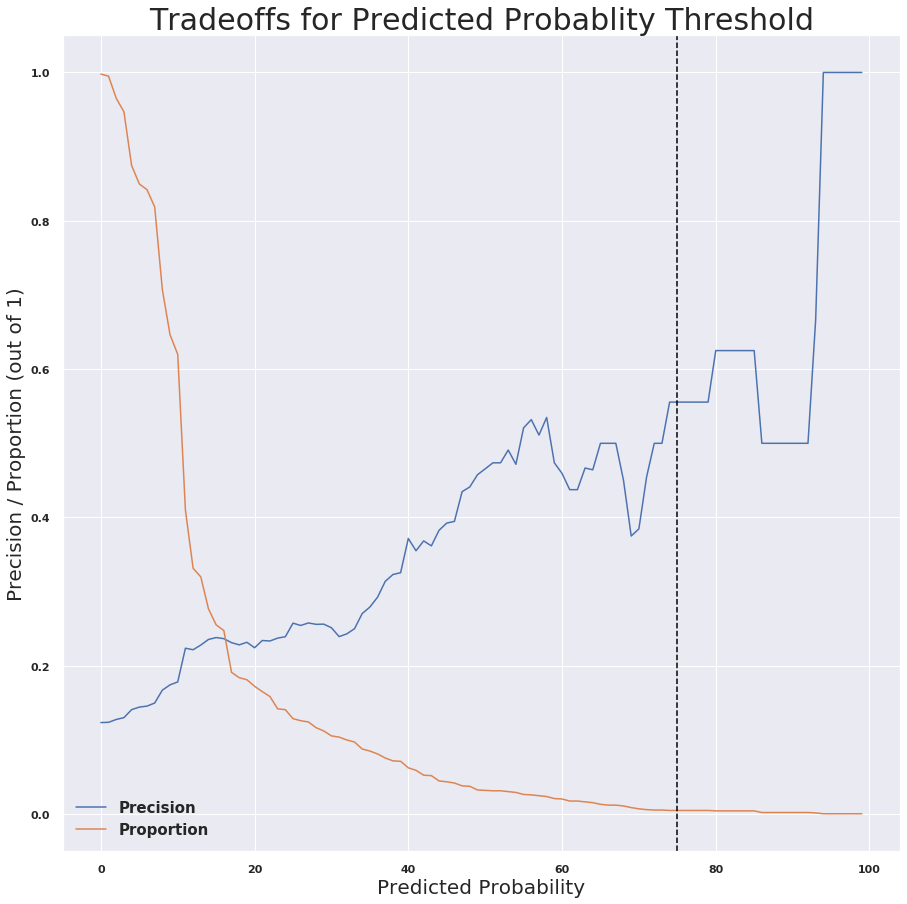

In [700]:
from matplotlib import pyplot
font = {'family' : 'normal',
        'size'   : 30}

# retrieve performance metrics
x_axis = no_show_precision['probability']
# plot log loss
fig, ax = pyplot.subplots(figsize=(15,15))
ax.plot(x_axis, no_show_precision['precision'], label='Precision')
ax.plot(x_axis, no_show_precision['proportion'], label='Proportion')
ax.legend(prop={'size': 15})
plt.axvline(75, color='black', linestyle='--')
pyplot.ylabel('Precision / Proportion (out of 1)', size=20)
pyplot.title('Tradeoffs for Predicted Probablity Threshold', size=30)
pyplot.xlabel('Predicted Probability', size=20)
pyplot.show()
fig.savefig("Tradeoffs.png")

In [ ]:
cutoff

In [498]:
#storing the pickled model. 
import pickle
##pickle model, code from Lindsay
##My model is called 'rf' (as you see above)- whatever you called your model, substitute that in for 'rf', below.
##Don't change anything else unless you really want to.
with open('insightMVP_model.pkl', 'wb') as fid:
    pickle.dump(model_xgb_PT, fid,2)  


In [ ]:

# Load the model from disk
loaded_model = pickle.load(open('insightMVP_model.pkl', 'rb'))



y_pred_model_xgb = loaded_model.predict_proba(X_test)

print("The AUC score of the XGB model is: " + str(np.round(roc_auc_score(y_test,pd.DataFrame(y_pred_model_xgb)[1]),2)))